## Data First

In [ ]:
import os
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


paras = {
    'lr': 1e-3,
    'momentum': 0.4,
    'epochs': 25,
    'batch': 128,
    'step': 5,
    'device': 'cuda:0' if torch.cuda.is_available() else 'cpu',

    # datas
    'path': 'D:\\data\\FashionMNIST\\' if os.name == 'nt' else '/home/ubuntu/Data/FashionMNIST',
}

# Normalize can make training easier
trainset = datasets.FashionMNIST(
    root=paras['path'],
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
testset = datasets.FashionMNIST(
    root=paras['path'],
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=paras['batch'],
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=paras['batch']
)

### Show some of the training images

__Labels__

Each training and test example is assigned to one of the following labels:

* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

classes = (
    'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
)

dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images[:8]
labels = labels[:8]


def show_imgs(imgs, labels: str):
    imgs = imgs[:8]
    npimg = imgs.numpy()
    for i in range(len(imgs)):
        npimg[i][0] = np.transpose(npimg[i][0])
    npimg = npimg.reshape((8*28, 28)).transpose()
    plt.imshow(npimg, cmap='gray')
    plt.title(labels)
    plt.show()


labs = ' | '.join('%5s' % classes[labels[j]] for j in range(len(labels)))
show_imgs(images, labs)

## Define the Network

### Define the  Residual Block

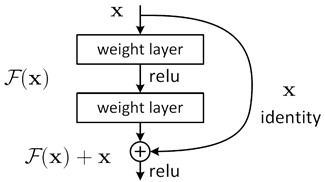

In [ ]:
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            self.relu,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        residual = x
        x = self.layers(x)
        x += residual
        x = self.relu(x)
        return x

### Define the ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block_type):
        super(ResNet, self).__init__()
        self.firstLayer = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.ResBlocks = nn.Sequential(
            block_type(8, 8),
            block_type(8, 8),
            block_type(8, 8),
            block_type(8, 8),
            block_type(8, 8),
            block_type(8, 8),
            block_type(8, 8),
            block_type(8, 8)
        )
        self.fcLayers = nn.Sequential(
            nn.Linear(8 * 26 * 26, 128),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.firstLayer(x)     # -> 8 @ 28*28
        x = self.ResBlocks(x)      # -> 8 @ 28*28
        x = x.view(x.size(0), -1)  # -> 8 * 28 * 28
        x = self.fcLayers(x)       # -> 10
        return x


resnet = ResNet(ResidualBlock)

## Load pretrained model

Before training, we can load model prtraind, so that making training much easier.

In [ ]:
resnet.load_state_dict(torch.load("resnet_97.pkl"))
print('Done')

## Training

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time


def train_model(model, name: str, criterion, optimizer, scheduler, epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc, test_acc = [], []
    since = time.time()

    for epoch in range(epochs):
        print("====Epoch {}====".format(epoch))
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()
            else:
                model.eval()

            loss_sum, corrects = 0.0, 0
            tic = time.time()

            loader = trainloader if phase == "train" else testloader
            for _, (inputs, labels) in enumerate(loader):
                inputs = inputs.to(paras["device"])
                labels = labels.to(paras["device"])
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                loss_sum += loss.item() * inputs.size(0)
                correct = torch.sum(preds == labels.data)
                corrects += correct
                if phase == 'train':
                    train_acc.append(correct)
                else:
                    test_acc.append(correct)

            toc = time.time()
            epoch_loss = loss_sum / len(loader.dataset)
            epoch_acc = corrects.double() / len(loader.dataset)
            print(
                "{} Loss: {:.4f} Acc: {:.4f} Cost: {:.2f} min".format(
                    phase, epoch_loss, epoch_acc, (toc - tic) / 60
                )
            )

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if epoch % 5 == 0:
                    wts_name = "{}_{:.4f}.pth".format(name, best_acc)
                    torch.save(best_model_wts, wts_name)

    time_elapsed = time.time() - since
    print("=" * 10)
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )
    print("*** Best val Acc: {:4f} ***".format(best_acc))

    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.legend(["Trainset accuracy", "Testset accuracy"])
    plt.show()

    wts_name = "{}_{:.4f}.pth".format(name, best_acc)
    torch.save(best_model_wts, wts_name)
    print("Saved model to {}".format(wts_name))


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=paras['lr'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=paras['step'], gamma=0.5)

resnet.to(paras['device'])
train_model(resnet, "ResNet", criterion, optimizer, scheduler, paras['epochs'])

## Testing and Saving the Trained Model

In [ ]:
import numpy as np

resnet.eval()

mtx = np.zeros((10, 10), dtype=np.int)

total, correct = 0, 0

for inputs, labels in testloader:
    inputs = Variable(inputs).to(paras['device'])
    labels = Variable(labels).to(paras['device'])

    outputs = resnet(inputs)
    _, predict = torch.max(outputs.data, 1)

    size = labels.size(0)
    total += size
    for i in range(size):
        mtx[predict[i]][labels[i]] += 1
    correct += (predict == labels).sum()

acc = 100 * correct / total
print("Accuracy: {:.2f} %".format(acc))
print(mtx)